# Notebook 3

Ce notebook est découpé en plusieurs axes de travail :

- Import des packages
- Import des données
- Premier réseau de neurones model sequentiel
- Deuxième réseau de neuronnes - Ajout de couches Dropout
- Troisième réseau de neurones - Réseau de neurones à couches convolutionnelles
- Quatrième réseau de neurones - Optimisation des paramètres sur le 3eme
- Visualisation des données prédites avecle Troisième réseau de neurones
- Mise en place de Grad Cam

# Import des packages

In [2]:
import numpy as np              # linear algebra
import pandas as pd             # data processing, CSV file I/O (e.g. pd.read_csv)
import os                       # files handling
import re
from PIL import Image
from random import randint, seed
from IPython.display import display
import matplotlib.pyplot as plt
import json
import warnings
import requests
import itertools
import seaborn as sns
warnings.filterwarnings('ignore')
import cv2
import tensorflow
from tensorflow import keras
from keras.models import Sequential # Pour construire un réseau de neurones
from keras.layers import Dense, Dropout, Flatten, LeakyReLU # Pour instancier une couche dense
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import des données

In [3]:
def load_jpeg_images(path):
    """
    Fonction qui charge toutes les images en format JPEG à partir du répertoire spécifié et les redimensionne en 100X100
    pixels. La fonction renvoie un DataFrame Pandas contenant les pixels des images, ainsi que leur label.

    Args:
        path (str): le chemin d'accès au répertoire contenant les images.

    Returns:
        pandas.DataFrame: un DataFrame Pandas contenant les pixels des images en format numpy, ainsi que leur label.
    """

    image_files = [f for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.jpeg')]
    images = []
    ids = []
    for file in image_files:
        ids.append(os.path.splitext(file)[0])
        with Image.open(os.path.join(path, file)) as image:
            image_data = np.array(image)
            img = cv2.resize(image_data, (100, 100))
            images.append(img)

    dataimage = pd.DataFrame({"ids": ids, "img": images})
    datachampi = pd.read_csv('/kaggle/input/images-bapti/dataframe/champignons.csv')

    datachampi = datachampi[['label', 'image_id']]

    dataimage[['ids']] = dataimage[['ids']].astype('int64')

    dataset = pd.merge(dataimage, datachampi, left_on='ids', right_on='image_id', how='left')

    return dataset

In [4]:
# Information sur la fonction
help(load_jpeg_images)
# Utilisation
df=load_jpeg_images('/kaggle/input/images-bapti/images')
# Voir les deux premieres lignes de la sortie 
df.head(2)

Help on function load_jpeg_images in module __main__:

load_jpeg_images(path)
    Fonction qui charge toutes les images en format JPEG à partir du répertoire spécifié et les redimensionne en 100X100
    pixels. La fonction renvoie un DataFrame Pandas contenant les pixels des images, ainsi que leur label.
    
    Args:
        path (str): le chemin d'accès au répertoire contenant les images.
    
    Returns:
        pandas.DataFrame: un DataFrame Pandas contenant les pixels des images en format numpy, ainsi que leur label.



,ids,img,label,image_id
0,286008,"[[[48, 44, 55], [45, 39, 49], [35, 28, 36], [3...",Hypholoma fasciculare,286008
1,458679,"[[[91, 76, 43], [99, 76, 65], [78, 50, 40], [1...",Pleurotus ostreatus,458679


# Preparation des données

In [5]:
df = df.drop(index=7802) # pas de bonne taille
# Mise en place du jeu de X et Y en numpy pour qu'il puisse être traité dans les réseaux de neuronnes
display(df.head())
X = df['img'].to_numpy()
Y = df['label'].to_numpy()

,ids,img,label,image_id
0,286008,"[[[48, 44, 55], [45, 39, 49], [35, 28, 36], [3...",Hypholoma fasciculare,286008
1,458679,"[[[91, 76, 43], [99, 76, 65], [78, 50, 40], [1...",Pleurotus ostreatus,458679
2,134968,"[[[95, 70, 81], [163, 142, 128], [81, 54, 37],...",Coprinus comatus,134968
3,333550,"[[[44, 38, 16], [43, 28, 11], [34, 15, 5], [60...",Pluteus cervinus,333550
4,428572,"[[[104, 107, 112], [106, 107, 111], [111, 111,...",Fuligo septica,428572


In [6]:
# X = [np.array(x) for x in X]
# Modification de la taille de X pour que tous ces éléments soient pris en compte dans ses dimensions
X = np.stack(X)
print(X.shape)
print(Y.shape)

(9447, 100, 100, 3)
(9447,)


Pour la préparation des données, nous sommes partis de 2 jeux de données. Nous avons du télécharger toutes les images et toutes les informations qui leur correspondait. Grâce au numéro d'indice, nous avons pu regrouper les images avec leur label

# Visualisation des données

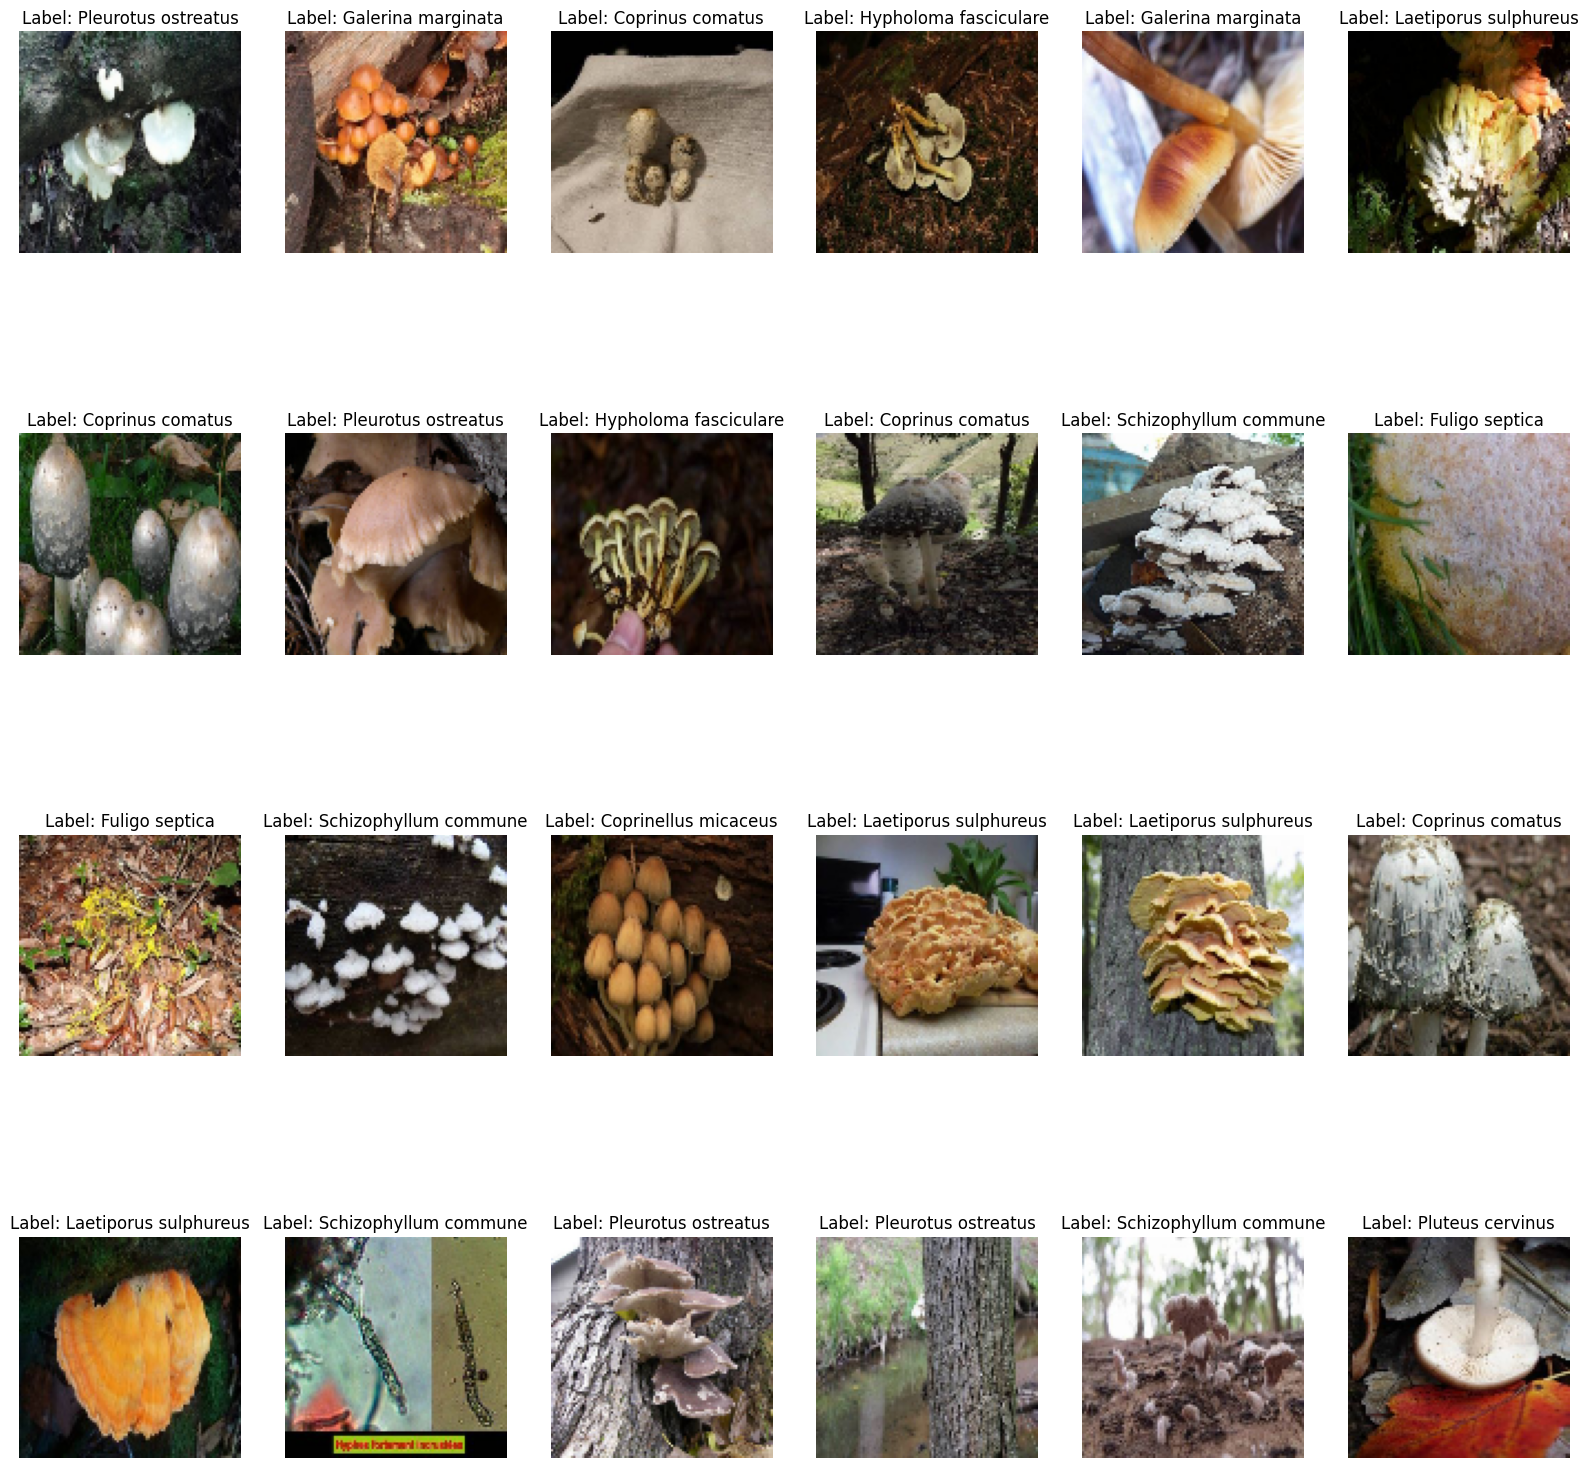

In [7]:
nb_col = 6
nb_lig = 4
j = 1

plt.figure(figsize=(20,20))

for i in np.random.choice(np.arange(0, len(Y)), size = nb_lig*nb_col):
    # On sélectionne une Image (corrspondant au nombre aléatorie choisi)
    sample0 = np.array(X[i]) 
    # Subplot nous permet de selectionner une des sous-figures parmi une grille. Dans notre cas la grille
    # a 2 lignes et 3 colonnes.
    plt.subplot(nb_lig, nb_col, j)
    j = j + 1
    
    # Suppresion des axes
    plt.axis('off')
    
    plt.imshow(sample0)

    # Modification du titre de la figure
    plt.title('Label: ' + str(Y[i]))

# Pre-processing

In [8]:
# One hot encoding
Y = pd.get_dummies(Y)

# Création du jeu d'entrainement et du jeu de test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25)
print('Les dimensions de X_train est de '+str(X_train.shape)+'.')
print('Les dimensions de Y_train est de '+str(Y_train.shape)+'.')
print('Les dimensions de X_test est de '+str(X_test.shape)+'.')
print('Les dimensions de Y_test est de '+str(Y_test.shape)+'.')

# Redimension des jeu de train
X_train1 = X_train.reshape([-1, X_train.shape[1]*X_train.shape[2]*X_train.shape[3]])
X_test1 = X_test.reshape([-1, X_test.shape[1]*X_test.shape[2]*X_train.shape[3]])

X_train1 = X_train1/255
X_test1 = X_test1/255

nb_pixel = X_train1.shape[1]
nb_class = Y_train.shape[1]

print("\n\nLe nombre de pixels est de : ", nb_pixel)
print("Le nombre de classes est de : ", nb_class)

Les dimensions de X_train est de (7085, 100, 100, 3).
Les dimensions de Y_train est de (7085, 10).
Les dimensions de X_test est de (2362, 100, 100, 3).
Les dimensions de Y_test est de (2362, 10).


Le nombre de pixels est de :  30000
Le nombre de classes est de :  10


Pour pouvoir commencer à construire un réseau de neurones. Il faut remplir quelques conditions :

- Avoir les données dans de bonnes dimensions
- Pour un model sequentiel il faut avoir les images en 1 dimensions
- Vérifier que les données de sorties soit labellisé correctement

# Deep Learning

In [9]:
def analyze_model(model, X_test, y_test, train_hist, epochs_nb = 20):
    """
    Fonction qui permet de présenter la prédiction du jeu de test et de visualiser les résultats de l'entrainement.

    Args:
        model (tensorflow.keras.models.Sequential): modèle entraîné.
        X_test (numpy.ndarray): données du jeu de test.
        y_test (numpy.ndarray): étiquettes du jeu de test.
        train_hist (tensorflow.python.keras.callbacks.History): historique de l'entraînement.
        epochs_nb (int): nombre d'époques.

    Returns:
        None
    """
    score = model.evaluate(X_test, y_test)  
    erreur = 100*(1-score[1])
    print('Perte sur le set de test: %4.3f '%score[0])
    print('Erreur sur le set de test:  %4.2f %%'% erreur)

    train_acc = train_hist.history['accuracy'] # récupère l'historique de l'accuracy sur les données d'entraînement
    val_acc = train_hist.history['val_accuracy'] # récupère l'historique de l'accuracy sur les données de validation
    
    epo = epochs_nb + 1
    
    # Affiche la courbe de l'accuracy sur les données d'entraînement et de validation en fonction des époques
    plt.figure(figsize = (10,7))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(np.arange(1, epo,1), train_acc, color = 'orange', label= 'accuracy')
    plt.plot(np.arange(1, epo,1), val_acc, color = 'blue', label= 'accuracy validation')
    plt.legend()
    plt.show();


# Premier réseaux de neurones model sequentiel

In [20]:
# Premier réseau de neuronnes model sequentiel
model = Sequential()
# Utilisation de 4 couches avec les activations tanh, relu, leakyrelu et softmax

first_layer = Dense(units = 150, 
                       input_dim = nb_pixel, 
                       activation = 'tanh', 
                       kernel_initializer = 'normal')

second_layer = Dense(units = 150,
                         activation = 'relu',
                         kernel_initializer = 'normal')

third_layer = Dense(units = 150,
                         activation = LeakyReLU(alpha=0.1),
                         kernel_initializer = 'normal')

four_layer = Dense(units = nb_class, 
                        activation = 'softmax', 
                        kernel_initializer = 'normal')

model.add(first_layer)
model.add(second_layer)
model.add(third_layer)
model.add(four_layer)

# Utilisation d'une dessente de gradient
model.compile(optimizer=keras.optimizers.SGD(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

display(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 150)               4500150   
                                                                 
 dense_17 (Dense)            (None, 150)               22650     
                                                                 
 dense_18 (Dense)            (None, 150)               22650     
                                                                 
 dense_19 (Dense)            (None, 10)                1510      
                                                                 
Total params: 4,546,960
Trainable params: 4,546,960
Non-trainable params: 0
_________________________________________________________________


None

In [21]:
training_history = model.fit(X_train1, Y_train, 
                                    batch_size=400, 
                                    epochs=250, 
                                    validation_split=0.2,
                                    verbose=1,
                                    initial_epoch=0,
                                    workers=-1)

Epoch 1/250
15/15 [==============================] - 2s 90ms/step - loss: 2.3116 - accuracy: 0.0813 - val_loss: 2.3075 - val_accuracy: 0.0790
Epoch 2/250
15/15 [==============================] - 1s 52ms/step - loss: 2.3024 - accuracy: 0.0977 - val_loss: 2.3005 - val_accuracy: 0.1073
Epoch 3/250
15/15 [==============================] - 1s 51ms/step - loss: 2.2954 - accuracy: 0.1288 - val_loss: 2.2952 - val_accuracy: 0.1327
Epoch 4/250
15/15 [==============================] - 1s 51ms/step - loss: 2.2899 - accuracy: 0.1463 - val_loss: 2.2915 - val_accuracy: 0.1348
Epoch 5/250
15/15 [==============================] - 1s 51ms/step - loss: 2.2859 - accuracy: 0.1521 - val_loss: 2.2886 - val_accuracy: 0.1418
Epoch 6/250
15/15 [==============================] - 1s 50ms/step - loss: 2.2827 - accuracy: 0.1516 - val_loss: 2.2861 - val_accuracy: 0.1426
Epoch 7/250
15/15 [==============================] - 1s 52ms/step - loss: 2.2800 - accuracy: 0.1516 - val_loss: 2.2841 - val_accuracy: 0.1433
Epoch 

74/74 [==============================] - 0s 4ms/step - loss: 2.2095 - accuracy: 0.2447
Perte sur le set de test: 2.210 
Erreur sur le set de test:  75.53 %


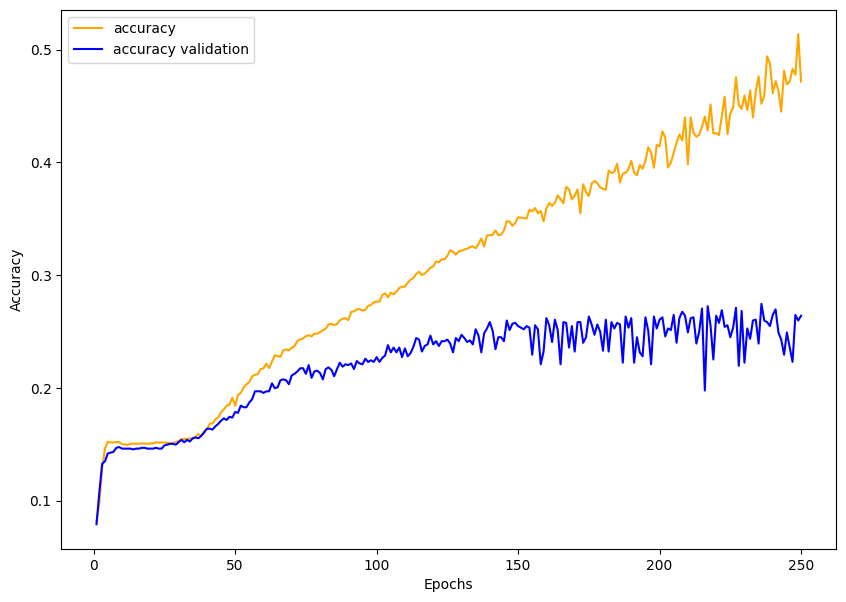

In [22]:
analyze_model(model,X_test1,Y_test,training_history,250)

# Deuxième réseau de neuronnes - Ajout de couches Dropout

In [23]:
# Deuxième réseau de neuronnes model sequentiel
# Utilisation de 4 couches avec les activations tanh, relu, leakyrelu et softmax en utilisant des couches DropOut
model2 = Sequential()

first_layer2 = Dense(units = 200, 
                       input_dim = nb_pixel, 
                       activation = 'tanh', 
                       kernel_initializer = 'normal')

five_layer2 = Dropout(rate = 0.5)

six_layer2 = Dense(units = 200,
                         activation = 'relu',
                         kernel_initializer = 'normal')

seven_layer2 = Dropout(rate = 0.5)

eigt_layer2 = Dense(units = 200,
                         activation = LeakyReLU(alpha=0.2),
                         kernel_initializer = 'normal')

nine_layer2 = Dropout(rate = 0.5)

ten_layer2 = Dense(units = nb_class, 
                        activation = 'softmax', 
                        kernel_initializer = 'normal')

model2.add(first_layer2)
model2.add(five_layer2)
model2.add(six_layer2)
model2.add(seven_layer2)
model2.add(eigt_layer2)
model2.add(nine_layer2)
model2.add(ten_layer2)

model2.compile(optimizer=keras.optimizers.SGD(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

display(model2.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 200)               6000200   
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_21 (Dense)            (None, 200)               40200     
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_22 (Dense)            (None, 200)               40200     
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_23 (Dense)            (None, 10)               

None

In [24]:
training_history2 = model2.fit(X_train1, Y_train, 
                                    batch_size=40, 
                                    epochs=250, 
                                    validation_split=0.3,
                                    verbose=1,
                                    initial_epoch=0,
                                    workers=-1)

Epoch 1/250
124/124 [==============================] - 3s 14ms/step - loss: 2.3451 - accuracy: 0.1162 - val_loss: 2.2832 - val_accuracy: 0.1482
Epoch 2/250
124/124 [==============================] - 1s 8ms/step - loss: 2.3183 - accuracy: 0.1196 - val_loss: 2.2785 - val_accuracy: 0.1482
Epoch 3/250
124/124 [==============================] - 1s 8ms/step - loss: 2.2969 - accuracy: 0.1351 - val_loss: 2.2770 - val_accuracy: 0.1482
Epoch 4/250
124/124 [==============================] - 1s 7ms/step - loss: 2.2923 - accuracy: 0.1359 - val_loss: 2.2713 - val_accuracy: 0.1472
Epoch 5/250
124/124 [==============================] - 1s 9ms/step - loss: 2.2830 - accuracy: 0.1468 - val_loss: 2.2645 - val_accuracy: 0.1529
Epoch 6/250
124/124 [==============================] - 1s 8ms/step - loss: 2.2801 - accuracy: 0.1464 - val_loss: 2.2603 - val_accuracy: 0.1609
Epoch 7/250
124/124 [==============================] - 1s 8ms/step - loss: 2.2779 - accuracy: 0.1555 - val_loss: 2.2580 - val_accuracy: 0.163

74/74 [==============================] - 0s 4ms/step - loss: 2.3205 - accuracy: 0.2718
Perte sur le set de test: 2.320 
Erreur sur le set de test:  72.82 %


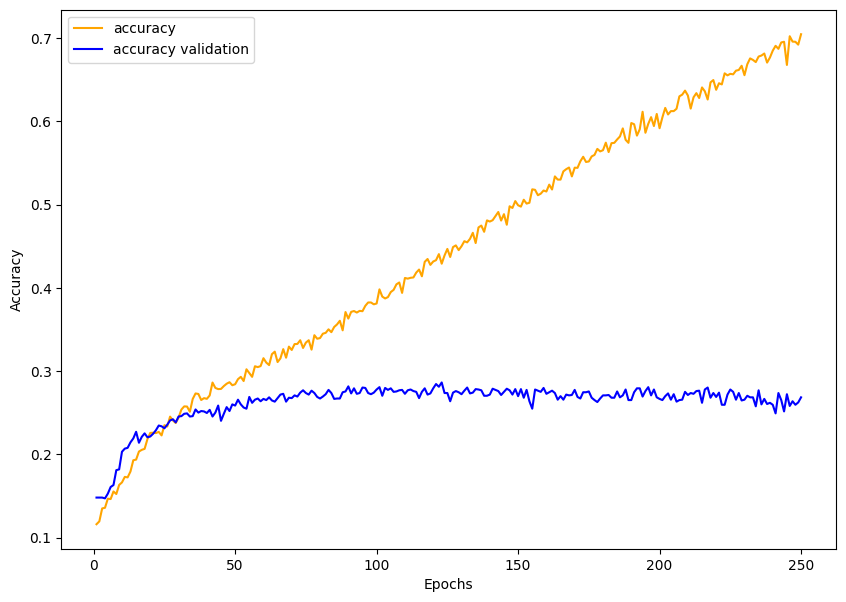

In [25]:
analyze_model(model2,X_test1,Y_test,training_history2,250)

# Troisième réseau de neurone - Réseau de neurones à couches convolutionnelles

In [10]:
# Redéfinition des données

# One hot encoding
Y = pd.get_dummies(Y)

# Création du jeu d'entrainement et du jeu de test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25)
print('Les dimensions de X_train est de '+str(X_train.shape)+'.')
print('Les dimensions de Y_train est de '+str(Y_train.shape)+'.')
print('Les dimensions de X_test est de '+str(X_test.shape)+'.')
print('Les dimensions de Y_test est de '+str(Y_test.shape)+'.')

# Normaliser
X_train2 = X_train/255
X_test2 = X_test/255

nb_class = Y_test.shape[1]
print('Le nombre de classe du jeu de donnée est ',str(nb_class))

Les dimensions de X_train est de (7085, 100, 100, 3).
Les dimensions de Y_train est de (7085, 10).
Les dimensions de X_test est de (2362, 100, 100, 3).
Les dimensions de Y_test est de (2362, 10).
Le nombre de classe du jeu de donnée est  10


In [11]:
# CNN
# Utilisation d'une couche de convolution
# utilisant des couches DropOut

model_CNN = Sequential()
first_layer_CNN = Conv2D(
    filters = 16, 
    kernel_size = (5, 5),
    padding = 'valid',
    input_shape = (100, 100, 3),
    activation = 'relu'
)
second_layer_CNN = MaxPooling2D(pool_size = (5, 5))
third_layer_CNN = Dropout(rate = 0.7)
fourth_layer_CNN = Flatten()
fifth_layer_CNN = Dense(units = 100, activation = 'relu')
six_layer_CNN = Dropout(rate = 0.7)
seven_layer_CNN = Dense(units = 100, activation = LeakyReLU(alpha=0.2))
eigt_layer_CNN = Dropout(rate = 0.7)
last_layer_CNN = Dense(units = nb_class, activation = 'softmax')

model_CNN.add(first_layer_CNN)
model_CNN.add(second_layer_CNN)
model_CNN.add(third_layer_CNN)
model_CNN.add(fourth_layer_CNN)
model_CNN.add(fifth_layer_CNN)
model_CNN.add(six_layer_CNN)
model_CNN.add(last_layer_CNN)

model_CNN.compile(optimizer=keras.optimizers.SGD(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


display(model_CNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 19, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 19, 16)        0         
                                                                 
 flatten (Flatten)           (None, 5776)              0         
                                                                 
 dense (Dense)               (None, 100)               577700    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                        

None

In [12]:
training_history3 = model_CNN.fit(X_train2, Y_train,  
                                  batch_size = 50, 
                                  epochs = 250,
                                  validation_split=0.3, 
                                  verbose=1)

Epoch 1/250


2023-05-03 17:03:49.936629: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 11s 23ms/step - loss: 2.3226 - accuracy: 0.1157 - val_loss: 2.2949 - val_accuracy: 0.1355
Epoch 2/250
100/100 [==============================] - 1s 12ms/step - loss: 2.2975 - accuracy: 0.1248 - val_loss: 2.2930 - val_accuracy: 0.1355
Epoch 3/250
100/100 [==============================] - 1s 11ms/step - loss: 2.2912 - accuracy: 0.1311 - val_loss: 2.2914 - val_accuracy: 0.1359
Epoch 4/250
100/100 [==============================] - 1s 10ms/step - loss: 2.2903 - accuracy: 0.1391 - val_loss: 2.2877 - val_accuracy: 0.1350
Epoch 5/250
100/100 [==============================] - 1s 11ms/step - loss: 2.2873 - accuracy: 0.1434 - val_loss: 2.2851 - val_accuracy: 0.1350
Epoch 6/250
100/100 [==============================] - 1s 11ms/step - loss: 2.2814 - accuracy: 0.1422 - val_loss: 2.2817 - val_accuracy: 0.1350
Epoch 7/250
100/100 [==============================] - 1s 11ms/step - loss: 2.2793 - accuracy: 0.1512 - val_loss: 2.2749 - val_accuracy: 0.1355
Epo

74/74 [==============================] - 0s 5ms/step - loss: 1.6581 - accuracy: 0.4297
Perte sur le set de test: 1.658 
Erreur sur le set de test:  57.03 %


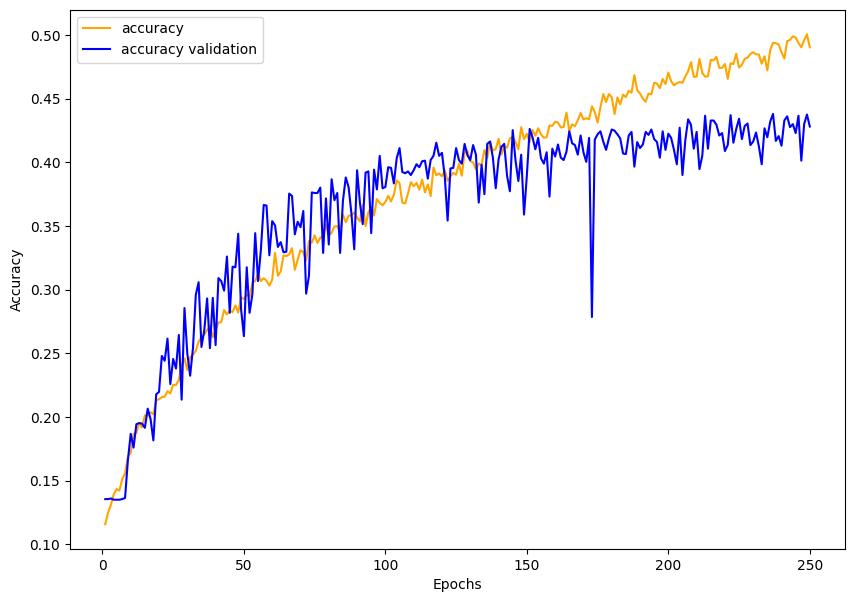

In [13]:
analyze_model(model_CNN,X_test2,Y_test,training_history3,250)

# Quatrième réseau de neurones - Optimisation des paramètres sur le 3eme


In [ ]:
# Définir la fonction qui construit votre modèle
def build_model(filters, kernel_size, padding, activation, dropout_rate, dense_units, leaky_alpha):
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, 
                     input_shape=(60, 60, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=100, activation=LeakyReLU(alpha=leaky_alpha)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=nb_class, activation='softmax'))
    model.compile(optimizer=keras.optimizers.SGD(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(build_fn=build_model, epochs=10, batch_size=32, verbose=0)

# Définir les hyperparamètres à tester
filters = [16, 32, 64]
kernel_size = [(3, 3), (5, 5), (7, 7)]
padding = ['valid', 'same']
activation = ['relu', 'sigmoid']
dropout_rate = [0.5, 0.7]
dense_units = [50, 100, 200]
leaky_alpha = [0.1, 0.2, 0.3]

# Créer un dictionnaire des hyperparamètres
param_grid = dict(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation,
                  dropout_rate=dropout_rate, dense_units=dense_units, leaky_alpha=leaky_alpha)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid.fit(X_test2, Y_test)

# Afficher les meilleurs hyperparamètres trouvés
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Afficher les résultats pour toutes les combinaisons d'hyperparamètres testées
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Visualisation des données prédites avecle Troisième réseau de neurones

In [14]:
proba_class_test = model_CNN.predict(X_test)
predict_class_test = proba_class_test.argmax(axis=1)
Y_test = Y_test.to_numpy()
Y_test_class = Y_test.argmax(axis=1)


print(metrics.classification_report(Y_test_class, predict_class_test))

74/74 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       195
           1       0.10      0.02      0.04       183
           2       0.75      0.02      0.04       259
           3       0.16      0.28      0.21       193
           4       0.15      0.04      0.07       261
           5       0.29      0.24      0.26       299
           6       0.12      0.88      0.21       198
           7       0.57      0.02      0.04       362
           8       0.00      0.00      0.00       198
           9       0.22      0.16      0.19       214

    accuracy                           0.15      2362
   macro avg       0.24      0.17      0.11      2362
weighted avg       0.27      0.15      0.11      2362



In [15]:
def print_nice_conf_matrix(y, cnf_matrix):
    '''
    Fonction dediee a rendre une jolie matrice de confusion a partir de :
        - y : un array contenant les classes pour la classification. Sert uniquement a compter le nombre de classes.
        - cnf_matrix : la matrice de confusion qui nous interesse.
    '''
    classes = range(0,(len(np.unique(y))))
    
    plt.figure()
    
    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment = "center",
                 color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")
    
    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.show()

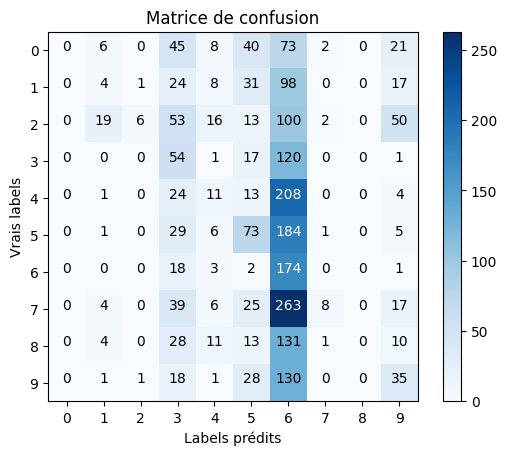

In [16]:
conf_matrix1 = confusion_matrix(Y_test_class, predict_class_test)

print_nice_conf_matrix(Y_test_class, conf_matrix1)

Cette matrice permet de voir nos prédictions avec la réalité.

# Mise en place de Grad cam

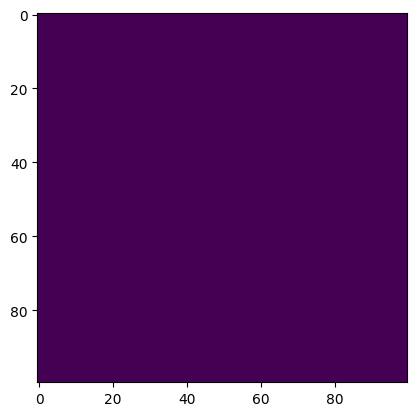

In [17]:
import tensorflow as tf
import keras.backend as K
from keras.preprocessing import image
import numpy as np
from PIL import Image

# Charger l'image à visualiser
img = Image.open('/kaggle/input/images-bapti/images/55969.jpg')
img = img.resize((100, 100))

x = np.array(img) / 255.0
x = x.reshape([1,x.shape[0],x.shape[1],x.shape[2]])

# Obtenir la sortie de la dernière couche convolutive
last_conv_layer = model_CNN.layers[0]
# Obtenir les activations de la dernière couche convolutive pour l'image donnée
activations = last_conv_layer(x)

# Calculer les gradients pour la classe prédite
class_index = 0  # Remplacer par l'indice de la classe souhaitée
with tf.GradientTape() as tape:
    tape.watch(activations)
    preds = model_CNN(x)
    class_output = preds[:, class_index]

grads = tape.gradient(class_output, activations)

if grads is not None:
    # Calculer la moyenne pondérée des gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # Multiplier chaque canal d'activation par son gradient moyen pondéré
    for i in range(pooled_grads.shape[-1]):
        activations[:, :, :, i] *= pooled_grads[i]
    # Calculer la carte de chaleur Grad-CAM en faisant la moyenne des activations pondérées
    heatmap = np.mean(activations, axis=-1)[0, :, :, :]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
else:
    # Retourner une carte de chaleur vide si les gradients ne peuvent pas être calculés
    heatmap = np.zeros((x.shape[1], x.shape[2]))

# Visualiser la carte de chaleur
plt.imshow(heatmap)
# Pas reussi à faire marcher correctement